# 1.0 An end-to-end classification problem (Training)



## 1.1 Dataset description

The notebooks focus on a borrower's **credit modeling problem**. The database was downloaded through a dataquest project and is available at link below. The data is from **Lending Club** and contains data from loans made in the period **2007 to 2011**. Lending Club is a marketplace for personal loans that matches borrowers who are seeking a loan with investors looking to lend money and make a return. The **target variable**, or what we are wanting to predict, is whether or not, given a person's history, they will repay the loan.

You can download the data from the [University of California, Irvine's website](http://archive.ics.uci.edu/ml/datasets/Adult).

Let's take the following steps:

1. ETL (done)
2. Data Checks (done)
3. Data Segregation (done)
4. Training

<center><img width="800" src="https://drive.google.com/uc?export=view&id=13kfVPzq-Jy-kH6GcJRfB44lIYAu5mtGl"></center>


## 1.2 Install, load libraries

In [1]:
!pip install wandb

     |████████████████████████████████| 1.8 MB 17.6 MB/s 
     |████████████████████████████████| 181 kB 56.8 MB/s 
     |████████████████████████████████| 145 kB 58.9 MB/s 
     |████████████████████████████████| 63 kB 2.0 MB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=26a1edf5b3256ae9ee7c106e1d582ed960a4c679e7bac62159e361555af8f8ae
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built pathtools


In [2]:
import logging
import wandb
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.tree import DecisionTreeClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import fbeta_score, precision_score, recall_score, accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [3]:
# Login to Weights & Biases
!wandb login --relogin

wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


## 1.3 Holdout Configuration

<center><img width="800" src="https://drive.google.com/uc?export=view&id=1C2SEVnhyEd_lBpdTuwL3aTxNXh5-ktVX"></center>

In [4]:
# global variables

# ratio used to split train and validation data
val_size = 0.30

# seed used to reproduce purposes
seed = 41

# reference (column) to stratify the data
stratify = "loan_status"

# name of the input artifact
artifact_input_name = "risk_credit/train.csv:latest"

# type of the artifact
artifact_type = "Train"

In [5]:
# configure logging
logging.basicConfig(level=logging.INFO,
                    format="%(asctime)s %(message)s",
                    datefmt='%d-%m-%Y %H:%M:%S')

# reference for a logging obj
logger = logging.getLogger()

# initiate the wandb project
run = wandb.init(project="risk_credit",job_type="train")

logger.info("Downloading and reading train artifact")
local_path = run.use_artifact(artifact_input_name).file()
df_train = pd.read_csv(local_path)

# Spliting train.csv into train and validation dataset
logger.info("Spliting data into train/val")
# split-out train/validation and test dataset
x_train, x_val, y_train, y_val = train_test_split(df_train.drop(labels=stratify,axis=1),
                                                  df_train[stratify],
                                                  test_size=val_size,
                                                  random_state=seed,
                                                  shuffle=True,
                                                  stratify=df_train[stratify])

wandb: Currently logged in as: morsinaldo. Use `wandb login --relogin` to force relogin


20-05-2022 19:05:57 Downloading and reading train artifact
20-05-2022 19:05:57 Spliting data into train/val


In [6]:
logger.info("x train: {}".format(x_train.shape))
logger.info("y train: {}".format(y_train.shape))
logger.info("x val: {}".format(x_val.shape))
logger.info("y val: {}".format(y_val.shape))

20-05-2022 19:06:16 x train: (18460, 17)
20-05-2022 19:06:16 y train: (18460,)
20-05-2022 19:06:16 x val: (7912, 17)
20-05-2022 19:06:16 y val: (7912,)


## 1.4 Data preparation

**Data preparation** may be the most important part of a machine learning project. 

```
It is the most time-consuming part, although it seems to be the least discussed topic. 
```

**Data preparation** sometimes referred to as **data preprocessing**, is the act of transforming raw data into a form that is appropriate for modeling. 

Machine learning algorithms require input data to be numbered, and most algorithm implementations maintain this expectation. As such, **if your data contains data types and values that are not numbers, such as labels, you will need to change the data into numbers**. Further, specific machine learning algorithms have expectations regarding the data types, scale, probability distribution, and relationships between input variables, and you may need to change the data to meet these expectations.

The philosophy of **data preparation** is to discover how to best expose the unknown underlying structure of the problem to the learning algorithms. This often requires **an iterative path of experimentation through a suite of different data preparation techniques** in order to discover what works well or best. The vast majority of the machine learning algorithms you may use on a project are years to decades old. **The implementation and application of the algorithms are well understood**. So much so that they are routine, with amazing, fully-featured open-source machine learning libraries like [scikit-learn](https://scikit-learn.org/stable/) in Python. 
```
The thing that is different from project to project is the data. 
```

You may be the first person (ever!) to use a specific dataset as the basis for a predictive modeling project. As such, the **preparation of the data** in order to best present it to the problem of the learning algorithms **is the primary task of any modern machine learning project**.

````
The challenge of data preparation is that each dataset is unique and different.
````

Datasets differ in the number of variables (tens, hundreds, thousands, or more), the types of the variables (numeric, nominal, ordinal, boolean), the scale of the variables, the drift in the values over time, and more. As such, this makes discussing data preparation a challenge. Either specific case studies are used, or focus is put on the general methods that can be used across projects. The result is that neither approach is explored.

### 1.4.1 Outlier Removal


<center><img width="800" src="https://drive.google.com/uc?export=view&id=1FMN6clRy5WuUPirbNStWFTk3LnxakWWW"></center>

In [7]:
logger.info("Outlier Removal")
# temporary variable
x = x_train.select_dtypes("float64").copy()

# identify outlier in the dataset
lof = LocalOutlierFactor()
outlier = lof.fit_predict(x)
mask = outlier != -1

20-05-2022 19:06:22 Outlier Removal


In [8]:
logger.info("x_train shape [original]: {}".format(x_train.shape))
logger.info("x_train shape [outlier removal]: {}".format(x_train.loc[mask,:].shape))

20-05-2022 19:06:22 x_train shape [original]: (18460, 17)
20-05-2022 19:06:22 x_train shape [outlier removal]: (18431, 17)


In [9]:
# AVOID data leakage and you should not do this procedure in the preprocessing stage
# Note that we did not perform this procedure in the validation set
x_train = x_train.loc[mask,:].copy()
y_train = y_train[mask].copy()

### 1.4.2 Encoding Target Variable

<center><img width="800" src="https://drive.google.com/uc?export=view&id=1oigyMuJiI5gGb9V185y_GN9skS0BRy5Y"></center>

In [10]:
y_train.head(10)

5525     Fully Paid
19011    Fully Paid
20964    Fully Paid
20533    Fully Paid
8244     Fully Paid
8138     Fully Paid
12371    Fully Paid
3891     Fully Paid
21678    Fully Paid
5197     Fully Paid
Name: loan_status, dtype: object

In [11]:
logger.info("Encoding Target Variable")
# define a categorical encoding for target variable
le = LabelEncoder()

# fit and transform y_train
y_train = le.fit_transform(y_train)

# transform y_test (avoiding data leakage)
y_val = le.transform(y_val)

logger.info("Classes [0, 1]: {}".format(le.inverse_transform([0, 1])))

20-05-2022 19:06:24 Encoding Target Variable
20-05-2022 19:06:24 Classes [0, 1]: ['Charged Off' 'Fully Paid']


In [12]:
y_train

array([1, 1, 1, ..., 1, 1, 0])

In [13]:
y_val

array([1, 0, 1, ..., 0, 1, 1])

### 1.4.3 Encoding independent variables [Experiment]


In [ ]:
x_train.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country
111,47,Private,344157,11th,7,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States
22049,47,Private,72880,Masters,14,Never-married,Prof-specialty,Not-in-family,White,Female,0,0,40,United-States
1080,44,Self-emp-inc,195124,HS-grad,9,Married-civ-spouse,Transport-moving,Husband,White,Male,0,0,60,?
22186,58,Federal-gov,30111,Some-college,10,Widowed,Prof-specialty,Unmarried,Amer-Indian-Eskimo,Female,0,0,40,United-States
6028,36,Private,162424,HS-grad,9,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,45,United-States


In [ ]:
x_train.workclass.unique()

array([' Private', ' Self-emp-inc', ' Federal-gov', ' State-gov',
       ' Local-gov', ' Self-emp-not-inc', ' ?', ' Without-pay',
       ' Never-worked'], dtype=object)

In [ ]:
x_train["sex"].values.shape

(14694,)

In [ ]:
x_train["sex"].values.reshape(-1,1).shape

(14694, 1)

In [ ]:
# just an experimentation

# drop=first erase redundant column
onehot = OneHotEncoder(sparse=False,drop="first")

# fit using x_train
onehot.fit(x_train["sex"].values.reshape(-1,1))

# make a copy
x_train_aux = x_train.copy()

# transform train 
x_train_aux[onehot.get_feature_names_out()] = onehot.transform(x_train_aux["sex"].values.reshape(-1,1))
x_train_aux.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,x0_ Male
111,47,Private,344157,11th,7,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,1.0
22049,47,Private,72880,Masters,14,Never-married,Prof-specialty,Not-in-family,White,Female,0,0,40,United-States,0.0
1080,44,Self-emp-inc,195124,HS-grad,9,Married-civ-spouse,Transport-moving,Husband,White,Male,0,0,60,?,1.0
22186,58,Federal-gov,30111,Some-college,10,Widowed,Prof-specialty,Unmarried,Amer-Indian-Eskimo,Female,0,0,40,United-States,0.0
6028,36,Private,162424,HS-grad,9,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,45,United-States,1.0


In [ ]:
# Inverse transformation
onehot.inverse_transform(np.array([0,1]).reshape(-1,1))

array([[' Female'],
       [' Male']], dtype=object)

In [ ]:
# Inverse transformation (other way)
onehot.inverse_transform([[0],[1]])

array([[' Female'],
       [' Male']], dtype=object)

In [ ]:
# Return the name of the new feature
onehot.get_feature_names_out()

array(['x0_ Male'], dtype=object)

### 1.4.4 Encoding independent variables

In [ ]:
# Show the shape of x train before transformation
x_train.shape

(14694, 14)

In [ ]:
# Lets review what are categorical columns
x_train.select_dtypes("object").columns.to_list()

['workclass',
 'education',
 'marital_status',
 'occupation',
 'relationship',
 'race',
 'sex',
 'native_country']

In [ ]:
# 08 columns are "object", lets transform them to categorical 
for name in x_train.select_dtypes("object").columns.to_list():
    onehot = OneHotEncoder(sparse=False,drop="first")
    # fit using x_train
    onehot.fit(x_train[name].values.reshape(-1,1))

    # transform train and validation
    x_train[onehot.get_feature_names_out()] = onehot.transform(x_train[name].values.reshape(-1,1))
    x_val[onehot.get_feature_names_out()] = onehot.transform(x_val[name].values.reshape(-1,1))

In [ ]:
x_train.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,...,x0_ Portugal,x0_ Puerto-Rico,x0_ Scotland,x0_ South,x0_ Taiwan,x0_ Thailand,x0_ Trinadad&Tobago,x0_ United-States,x0_ Vietnam,x0_ Yugoslavia
111,47,Private,344157,11th,7,Divorced,Handlers-cleaners,Not-in-family,White,Male,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
22049,47,Private,72880,Masters,14,Never-married,Prof-specialty,Not-in-family,White,Female,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1080,44,Self-emp-inc,195124,HS-grad,9,Married-civ-spouse,Transport-moving,Husband,White,Male,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22186,58,Federal-gov,30111,Some-college,10,Widowed,Prof-specialty,Unmarried,Amer-Indian-Eskimo,Female,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
6028,36,Private,162424,HS-grad,9,Married-civ-spouse,Craft-repair,Husband,White,Male,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [ ]:
x_val.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,...,x0_ Portugal,x0_ Puerto-Rico,x0_ Scotland,x0_ South,x0_ Taiwan,x0_ Thailand,x0_ Trinadad&Tobago,x0_ United-States,x0_ Vietnam,x0_ Yugoslavia
8819,19,Private,472807,1st-4th,2,Never-married,Handlers-cleaners,Other-relative,White,Male,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3807,41,Self-emp-not-inc,223763,Masters,14,Married-civ-spouse,Craft-repair,Husband,White,Male,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
14150,33,Private,133278,HS-grad,9,Never-married,Adm-clerical,Own-child,Black,Female,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
18800,44,Private,162643,HS-grad,9,Never-married,Adm-clerical,Not-in-family,White,Female,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
20818,23,Private,156513,HS-grad,9,Never-married,Handlers-cleaners,Own-child,Black,Male,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [ ]:
cols=['workclass','education','marital_status','occupation',
      'relationship','race','sex','native_country']

x_train.drop(labels=cols,axis=1,inplace=True)
x_val.drop(labels=cols,axis=1,inplace=True)

In [ ]:
x_train.head()

,age,fnlwgt,education_num,capital_gain,capital_loss,hours_per_week,x0_ Federal-gov,x0_ Local-gov,x0_ Never-worked,x0_ Private,...,x0_ Portugal,x0_ Puerto-Rico,x0_ Scotland,x0_ South,x0_ Taiwan,x0_ Thailand,x0_ Trinadad&Tobago,x0_ United-States,x0_ Vietnam,x0_ Yugoslavia
111,47,344157,7,0,0,40,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
22049,47,72880,14,0,0,40,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1080,44,195124,9,0,0,60,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22186,58,30111,10,0,0,40,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
6028,36,162424,9,0,0,45,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [ ]:
x_val.head()

,age,fnlwgt,education_num,capital_gain,capital_loss,hours_per_week,x0_ Federal-gov,x0_ Local-gov,x0_ Never-worked,x0_ Private,...,x0_ Portugal,x0_ Puerto-Rico,x0_ Scotland,x0_ South,x0_ Taiwan,x0_ Thailand,x0_ Trinadad&Tobago,x0_ United-States,x0_ Vietnam,x0_ Yugoslavia
8819,19,472807,2,0,0,52,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3807,41,223763,14,0,0,65,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
14150,33,133278,9,0,0,40,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
18800,44,162643,9,0,0,43,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
20818,23,156513,9,0,0,40,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In thesis, after this encoding process the dataset is ready to be trained. 

In [ ]:
# close the current run before to execute the next section
run.finish()

### 1.4.5 Using a full-pipeline

```
A reproducible pipeline is all you need
```

To follow the next cells' execution, it is important you re-run all cells at:
- Section 1.3
- Section 1.4.1
- Section 1.4.2

These steps are necessary to guarantee the raw ```train.csv``` is used.

#### 1.4.5.1 Feature Extractor

In [14]:
class FeatureSelector(BaseEstimator, TransformerMixin):
    # Class Constructor
    def __init__(self, feature_names):
        self.feature_names = feature_names

    # Return self nothing else to do here
    def fit(self, X, y=None):
        return self

    # Method that describes what this custom transformer need to do
    def transform(self, X, y=None):
        return X[self.feature_names]

In [15]:
# for validation purposes
fs = FeatureSelector(x_train.select_dtypes("object").columns.to_list())
df = fs.fit_transform(x_train)
df.head()

,term,emp_length,home_ownership,verification_status,purpose
5525,60 months,< 1 year,RENT,Source Verified,wedding
19011,36 months,10+ years,MORTGAGE,Verified,other
20964,36 months,5 years,RENT,Source Verified,debt_consolidation
20533,36 months,3 years,MORTGAGE,Not Verified,credit_card
8244,36 months,3 years,RENT,Verified,other


In [16]:
# for validation purposes
fs = FeatureSelector(x_train.select_dtypes("float64").columns.to_list())
df = fs.fit_transform(x_train)
df.head()

,loan_amnt,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc
5525,14400.0,17.93,243.42,120000.0,21.60,0.0,0.0,15.0,0.0,25420.0,73.3,25.0
19011,16000.0,11.71,529.22,88000.0,19.95,0.0,0.0,8.0,0.0,12075.0,41.2,56.0
20964,10000.0,7.88,312.82,64800.0,13.98,0.0,2.0,7.0,0.0,364.0,1.6,26.0
20533,5700.0,6.91,175.77,45000.0,7.57,0.0,1.0,4.0,0.0,5057.0,56.2,23.0
8244,2000.0,10.99,65.47,50400.0,24.71,0.0,0.0,22.0,0.0,27541.0,88.8,30.0


#### 1.4.5.2 Handling Categorical Features

In [17]:
# Handling categorical features
class CategoricalTransformer(BaseEstimator, TransformerMixin):
    # Class constructor method that takes one boolean as its argument
    def __init__(self, new_features=True, colnames=None):
        self.new_features = new_features
        self.colnames = colnames

    # Return self nothing else to do here
    def fit(self, X, y=None):
        return self

    def get_feature_names_out(self):
        return self.colnames.tolist()

    # Transformer method we wrote for this transformer
    def transform(self, X, y=None):
        df = pd.DataFrame(X, columns=self.colnames)

        # Remove white space in categorical features
        df = df.apply(lambda row: row.str.strip())

        # customize feature?
        # How can I identify what needs to be modified? EDA!!!!
        if self.new_features:

            #adjust emp_lenght feature
            mapping_dict = {
                "emp_length": {
                    "10+ years": 10,
                    "9 years": 9,
                    "8 years": 8,
                    "7 years": 7,
                    "6 years": 6,
                    "5 years": 5,
                    "4 years": 4,
                    "3 years": 3,
                    "2 years": 2,
                    "1 year": 1,
                    "< 1 year": 0,
                    "n/a": 0
                }
            }
            df = df.replace(mapping_dict)

        # update column names
        self.colnames = df.columns
            
        return df


In [18]:
# for validation purposes
fs = FeatureSelector(x_train.select_dtypes("object").columns.to_list())
df = fs.fit_transform(x_train)
df.head()

,term,emp_length,home_ownership,verification_status,purpose
5525,60 months,< 1 year,RENT,Source Verified,wedding
19011,36 months,10+ years,MORTGAGE,Verified,other
20964,36 months,5 years,RENT,Source Verified,debt_consolidation
20533,36 months,3 years,MORTGAGE,Not Verified,credit_card
8244,36 months,3 years,RENT,Verified,other


In [19]:
# for validation purposes
ct = CategoricalTransformer(new_features=True,colnames=df.columns.tolist())
df_cat = ct.fit_transform(df)
df_cat.head()

,term,emp_length,home_ownership,verification_status,purpose
5525,60 months,0,RENT,Source Verified,wedding
19011,36 months,10,MORTGAGE,Verified,other
20964,36 months,5,RENT,Source Verified,debt_consolidation
20533,36 months,3,MORTGAGE,Not Verified,credit_card
8244,36 months,3,RENT,Verified,other


In [20]:
# check the cardinality before and after transformation
x_train.select_dtypes("object").apply(pd.Series.nunique)

term                    2
emp_length             11
home_ownership          5
verification_status     3
purpose                14
dtype: int64

In [21]:
# check the cardinality before and after transformation
df_cat.apply(pd.Series.nunique)

term                    2
emp_length             11
home_ownership          5
verification_status     3
purpose                14
dtype: int64

#### 1.4.5.3 Handling Numerical Features

In [22]:
# transform numerical features
class NumericalTransformer(BaseEstimator, TransformerMixin):
    # Class constructor method that takes a model parameter as its argument
    # model 0: minmax
    # model 1: standard
    # model 2: without scaler
    def __init__(self, model=0, colnames=None):
        self.model = model
        self.colnames = colnames
        self.scaler = None

    # Fit is used only to learn statistical about Scalers
    def fit(self, X, y=None):
        df = pd.DataFrame(X, columns=self.colnames)
        # minmax
        if self.model == 0:
            self.scaler = MinMaxScaler()
            self.scaler.fit(df)
        # standard scaler
        elif self.model == 1:
            self.scaler = StandardScaler()
            self.scaler.fit(df)
        return self

    # return columns names after transformation
    def get_feature_names_out(self):
        return self.colnames

    # Transformer method we wrote for this transformer
    # Use fitted scalers
    def transform(self, X, y=None):
        df = pd.DataFrame(X, columns=self.colnames)

        # update columns name
        self.colnames = df.columns.tolist()

        # minmax
        if self.model == 0:
            # transform data
            df = self.scaler.transform(df)
        elif self.model == 1:
            # transform data
            df = self.scaler.transform(df)
        else:
            df = df.values

        return df

In [23]:
# for validation purposes
fs = FeatureSelector(x_train.select_dtypes("float64").columns.to_list())
df = fs.fit_transform(x_train)
df.head()

,loan_amnt,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc
5525,14400.0,17.93,243.42,120000.0,21.60,0.0,0.0,15.0,0.0,25420.0,73.3,25.0
19011,16000.0,11.71,529.22,88000.0,19.95,0.0,0.0,8.0,0.0,12075.0,41.2,56.0
20964,10000.0,7.88,312.82,64800.0,13.98,0.0,2.0,7.0,0.0,364.0,1.6,26.0
20533,5700.0,6.91,175.77,45000.0,7.57,0.0,1.0,4.0,0.0,5057.0,56.2,23.0
8244,2000.0,10.99,65.47,50400.0,24.71,0.0,0.0,22.0,0.0,27541.0,88.8,30.0


In [24]:
# for validation purposes
nt = NumericalTransformer(model=1)
df_num = nt.fit_transform(df)
df_num

array([[ 0.43105921,  1.61158526, -0.39726645, ...,  0.76559949,
         0.86201652,  0.26250589],
       [ 0.64767724, -0.07295841,  0.96521003, ..., -0.0789009 ,
        -0.27370592,  2.99922025],
       [-0.16464039, -1.11022565, -0.06642017, ..., -0.81999824,
        -1.67478408,  0.350787  ],
       ...,
       [ 1.18922233, -0.23545458,  0.52056978, ..., -0.58300656,
        -1.31390032, -1.59139738],
       [-0.69264684, -0.26795382, -0.92557171, ..., -0.08605178,
         1.44933716, -0.62030519],
       [-0.16464039,  0.33599029,  0.05366654, ...,  0.09493519,
         0.97169688, -1.23827295]])

In [25]:
# return columns name
nt.get_feature_names_out()

['loan_amnt',
 'int_rate',
 'installment',
 'annual_inc',
 'dti',
 'delinq_2yrs',
 'inq_last_6mths',
 'open_acc',
 'pub_rec',
 'revol_bal',
 'revol_util',
 'total_acc']

#### 1.4.5.4 Data Preparation Pipeline

In [26]:
# model = 0 (min-max), 1 (z-score), 2 (without normalization)
numerical_model = 0

# Categrical features to pass down the categorical pipeline
categorical_features = x_train.select_dtypes("object").columns.to_list()

# Numerical features to pass down the numerical pipeline
numerical_features = x_train.select_dtypes("float64").columns.to_list()

# Defining the steps for the categorical pipeline
categorical_pipeline = Pipeline(steps=[('cat_selector', FeatureSelector(categorical_features)),
                                       ('imputer_cat', SimpleImputer(strategy="most_frequent")),
                                       ('cat_transformer', CategoricalTransformer(colnames=categorical_features)),
                                       # ('cat_encoder','passthrough'
                                       ('cat_encoder', OneHotEncoder(handle_unknown="ignore",sparse=False, drop="first"))
                                       ]
                                )

# Defining the steps in the numerical pipeline
numerical_pipeline = Pipeline(steps=[('num_selector', FeatureSelector(numerical_features)),
                                     ('imputer_num', SimpleImputer(strategy="median")),
                                     ('num_transformer', NumericalTransformer(numerical_model, 
                                                                              colnames=numerical_features))])

# Combine numerical and categorical pieplines into one full big pipeline horizontally
full_pipeline_preprocessing = FeatureUnion(transformer_list=[('cat_pipeline', categorical_pipeline),
                                                             ('num_pipeline', numerical_pipeline)]
                              )

In [27]:
# for validation purposes
new_data = full_pipeline_preprocessing.fit_transform(x_train)
# cat_names is a numpy array
cat_names = full_pipeline_preprocessing.get_params()["cat_pipeline"][3].get_feature_names_out().tolist()
# num_names is a list
num_names = full_pipeline_preprocessing.get_params()["num_pipeline"][2].get_feature_names_out()
df = pd.DataFrame(new_data,columns = cat_names + num_names)
df.head()

,term_60 months,emp_length_1,emp_length_2,emp_length_3,emp_length_4,emp_length_5,emp_length_6,emp_length_7,emp_length_8,emp_length_9,...,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.176550,0.127517,0.721202,0.0,0.000,0.325,0.0,0.170003,0.733734,0.261364
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.398724,0.091723,0.666110,0.0,0.000,0.150,0.0,0.080755,0.412412,0.613636
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.230500,0.065772,0.466778,0.0,0.250,0.125,0.0,0.002434,0.016016,0.272727
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.123960,0.043624,0.252755,0.0,0.125,0.050,0.0,0.033820,0.562563,0.238636
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.038216,0.049664,0.825042,0.0,0.000,0.500,0.0,0.184187,0.888889,0.318182


In [28]:
df.shape

(18431, 42)

In [29]:
x_train.shape

(18431, 17)

In [30]:
y_train.shape

(18431,)

## 1.5 Holdout Training

In this example the inference artifacts are:
- pipe (contains trained model and the preprocesing pipeline)
- le (label encoder object used to encode the target variable)

In [ ]:
# The full pipeline 
pipe = Pipeline(steps = [('full_pipeline', full_pipeline_preprocessing),
                         ("classifier",DecisionTreeClassifier())
                         ]
                )

# training
logger.info("Training")
pipe.fit(x_train, y_train)

# predict
logger.info("Infering")
predict = pipe.predict(x_val)

# Evaluation Metrics
logger.info("Evaluation metrics")
fbeta = fbeta_score(y_val, predict, beta=1, zero_division=1)
precision = precision_score(y_val, predict, zero_division=1)
recall = recall_score(y_val, predict, zero_division=1)
acc = accuracy_score(y_val, predict)

logger.info("Accuracy: {}".format(acc))
logger.info("Precision: {}".format(precision))
logger.info("Recall: {}".format(recall))
logger.info("F1: {}".format(fbeta))

19-05-2022 01:08:29 Training
19-05-2022 01:08:29 Infering
19-05-2022 01:08:29 Evaluation metrics
19-05-2022 01:08:29 Accuracy: 0.7635237613751263
19-05-2022 01:08:29 Precision: 0.8693754702784048
19-05-2022 01:08:29 Recall: 0.8520648967551623
19-05-2022 01:08:29 F1: 0.8606331471135942


In [ ]:
run.summary["Acc"] = acc
run.summary["Precision"] = precision
run.summary["Recall"] = recall
run.summary["F1"] = fbeta

In [ ]:
# predict bias
logger.info("Infering Bias")
predict_bias = pipe.predict(x_train)

# Evaluation Metrics
logger.info("Bias Evaluation metrics")
fbeta = fbeta_score(y_train, predict_bias, beta=1, zero_division=1)
precision = precision_score(y_train, predict_bias, zero_division=1)
recall = recall_score(y_train, predict_bias, zero_division=1)
acc = accuracy_score(y_train, predict_bias)

logger.info("Bias Accuracy: {}".format(acc))
logger.info("Bias Precision: {}".format(precision))
logger.info("Bias Recall: {}".format(recall))
logger.info("Bias F1: {}".format(fbeta))

19-05-2022 01:08:34 Infering Bias
19-05-2022 01:08:35 Bias Evaluation metrics
19-05-2022 01:08:35 Bias Accuracy: 1.0
19-05-2022 01:08:35 Bias Precision: 1.0
19-05-2022 01:08:35 Bias Recall: 1.0
19-05-2022 01:08:35 Bias F1: 1.0


In [ ]:
# Compare the accuracy, precision, recall with previous ones
print(classification_report(y_val,predict))

              precision    recall  f1-score   support

           0       0.21      0.23      0.22      1132
           1       0.87      0.85      0.86      6780

    accuracy                           0.76      7912
   macro avg       0.54      0.54      0.54      7912
weighted avg       0.77      0.76      0.77      7912



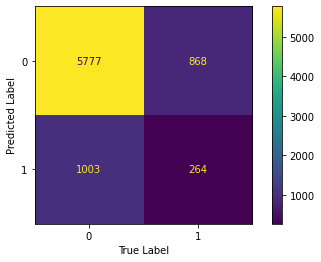

In [ ]:
fig_confusion_matrix, ax = plt.subplots(1,1,figsize=(7,4))
ConfusionMatrixDisplay(confusion_matrix(predict,y_val,labels=[1,0]),
                       display_labels=["0","1"]).plot(values_format=".0f",ax=ax)

ax.set_xlabel("True Label")
ax.set_ylabel("Predicted Label")
plt.show()

In [ ]:
# Uploading figures
logger.info("Uploading figures")
run.log(
    {
        "confusion_matrix": wandb.Image(fig_confusion_matrix),
        # "other_figure": wandb.Image(other_fig)
    }
)

19-05-2022 01:08:42 Uploading figures


In [ ]:
# Feature importance
pipe.get_params()["classifier"].feature_importances_

array([0.01032797, 0.00873547, 0.00897352, 0.00806163, 0.00602874,
       0.0099869 , 0.00558303, 0.00727893, 0.00415111, 0.00255946,
       0.00892393, 0.        , 0.00066476, 0.00773615, 0.00934106,
       0.01006431, 0.00810787, 0.00448698, 0.01084206, 0.00079518,
       0.00246192, 0.00123585, 0.00285634, 0.00395229, 0.00345306,
       0.0060701 , 0.00165999, 0.00606701, 0.00203361, 0.00217695,
       0.04857709, 0.10798829, 0.08001357, 0.09855761, 0.09323051,
       0.01154117, 0.02462501, 0.06213204, 0.00886442, 0.11541418,
       0.09996125, 0.08447869])

In [ ]:
# Get categorical column names
cat_names = pipe.named_steps['full_pipeline'].get_params()["cat_pipeline"][3].get_feature_names_out().tolist()
cat_names

['term_60 months',
 'emp_length_1',
 'emp_length_2',
 'emp_length_3',
 'emp_length_4',
 'emp_length_5',
 'emp_length_6',
 'emp_length_7',
 'emp_length_8',
 'emp_length_9',
 'emp_length_10',
 'home_ownership_NONE',
 'home_ownership_OTHER',
 'home_ownership_OWN',
 'home_ownership_RENT',
 'verification_status_Source Verified',
 'verification_status_Verified',
 'purpose_credit_card',
 'purpose_debt_consolidation',
 'purpose_educational',
 'purpose_home_improvement',
 'purpose_house',
 'purpose_major_purchase',
 'purpose_medical',
 'purpose_moving',
 'purpose_other',
 'purpose_renewable_energy',
 'purpose_small_business',
 'purpose_vacation',
 'purpose_wedding']

In [ ]:
# Get numerical column names
num_names = pipe.named_steps['full_pipeline'].get_params()["num_pipeline"][2].get_feature_names_out()
num_names

['loan_amnt',
 'int_rate',
 'installment',
 'annual_inc',
 'dti',
 'delinq_2yrs',
 'inq_last_6mths',
 'open_acc',
 'pub_rec',
 'revol_bal',
 'revol_util',
 'total_acc']

In [ ]:
# merge all column names together
all_names = cat_names + num_names
all_names

['term_60 months',
 'emp_length_1',
 'emp_length_2',
 'emp_length_3',
 'emp_length_4',
 'emp_length_5',
 'emp_length_6',
 'emp_length_7',
 'emp_length_8',
 'emp_length_9',
 'emp_length_10',
 'home_ownership_NONE',
 'home_ownership_OTHER',
 'home_ownership_OWN',
 'home_ownership_RENT',
 'verification_status_Source Verified',
 'verification_status_Verified',
 'purpose_credit_card',
 'purpose_debt_consolidation',
 'purpose_educational',
 'purpose_home_improvement',
 'purpose_house',
 'purpose_major_purchase',
 'purpose_medical',
 'purpose_moving',
 'purpose_other',
 'purpose_renewable_energy',
 'purpose_small_business',
 'purpose_vacation',
 'purpose_wedding',
 'loan_amnt',
 'int_rate',
 'installment',
 'annual_inc',
 'dti',
 'delinq_2yrs',
 'inq_last_6mths',
 'open_acc',
 'pub_rec',
 'revol_bal',
 'revol_util',
 'total_acc']

In [ ]:
# Visualize all classifier plots
# For a complete documentation please see: https://docs.wandb.ai/guides/integrations/scikit
wandb.sklearn.plot_classifier(pipe.get_params()["classifier"],
                              full_pipeline_preprocessing.transform(x_train),
                              full_pipeline_preprocessing.transform(x_val),
                              y_train,
                              y_val,
                              predict,
                              pipe.predict_proba(x_val),
                              [0,1],
                              model_name='DT', feature_names=all_names)

wandb: 
wandb: Plotting DT.
wandb: Logged feature importances.
wandb: Logged confusion matrix.
wandb: Logged summary metrics.
wandb: Logged class proportions.
wandb: Logged calibration curve.
wandb: WARNING wandb.plots.* functions are deprecated and will be removed in a future release. Please use wandb.plot.* instead.
wandb: Logged roc curve.
wandb: Logged precision-recall curve.


In [ ]:
# Visualize single plot
wandb.sklearn.plot_confusion_matrix(y_val, predict, [0,1])

In [ ]:
# Catch up the class proportions between train and validation
wandb.sklearn.plot_class_proportions(y_train, y_val, [0,1])

In [ ]:
# Plot the importance of columns
wandb.sklearn.plot_feature_importances(pipe.get_params()["classifier"],all_names)

In [ ]:
# Plot a brief summary of the weighted avg results (recall, precision, f1, acc)
wandb.sklearn.plot_summary_metrics(pipe.get_params()["classifier"],
                                    full_pipeline_preprocessing.transform(x_train),
                                    y_train,
                                    full_pipeline_preprocessing.transform(x_val),
                                    y_val)

In [ ]:
# ROC curve
predict_proba = pipe.predict_proba(x_val)
wandb.sklearn.plot_roc(y_val, predict_proba, [0,1])

In [ ]:
person1 = pd.DataFrame([[5000.0,'36 months', 5, 162.87, "10+ years", "RENT", 24000, "Verified", "car", 27.65,
                0.0, 1.0, 3.0, 0.0, 13648.0, 83.7, 9.0]], columns=x_train.columns)
pred = pipe.predict(person1)
print(pred[0])

1


In [ ]:
person2 = pd.DataFrame([[21000.0,'36 months', 12.42, 701.73, "10+ years", "RENT", 105000, "Verified", "debt_consolidation", 13.22,
                0.0, 0.0, 7.0, 0.0, 32135.0, 90.3, 38.0]], columns=x_train.columns)
print(pipe.predict(person2))

[0]


In [ ]:
# close the current run before to execute the next section
run.finish()

Acc,0.76352
F1,0.86063
Precision,0.86938
Recall,0.85206


## 1.6 Hyperparameter Tuning

In [ ]:
# To see all parameters of a specific step of the pipeline
# pipe.named_steps['classifier'].get_params() #or
# pipe.named_steps['full_pipeline'].get_params()

In [ ]:
# global seed
seed = 41

In [ ]:
sweep_config = {
    # try grid or random
    "method": "random",
    "metric": {
        "name": "Accuracy",
        "goal": "maximize"
        },
    "parameters": {
        "criterion": {
            "values": ["gini","entropy"]
            },
        "splitter": {
            "values": ["random","best"]
        },
        "model": {
            "values": [0,1,2]
        },
        "random_state": {
            "values": [seed]
        }
    }
}

sweep_id = wandb.sweep(sweep_config, project="decision_tree")

Create sweep with ID: n096ri00
Sweep URL: https://wandb.ai/morsinaldo/decision_tree/sweeps/n096ri00


In [ ]:
def train():
    with wandb.init() as run:

        # The full pipeline 
        pipe = Pipeline(steps = [('full_pipeline', full_pipeline_preprocessing),
                                    ("classifier",DecisionTreeClassifier())
                                    ]
                        )

        # update the parameters of the pipeline that we would like to tuning
        pipe.set_params(**{"full_pipeline__num_pipeline__num_transformer__model": run.config.model})
        pipe.set_params(**{"classifier__criterion": run.config.criterion})
        pipe.set_params(**{"classifier__splitter": run.config.splitter})
        pipe.set_params(**{"classifier__random_state": run.config.random_state})

        # training
        logger.info("Training")
        pipe.fit(x_train, y_train)

        # predict
        logger.info("Infering")
        predict = pipe.predict(x_val)

        # Evaluation Metrics
        logger.info("Evaluation metrics")
        fbeta = fbeta_score(y_val, predict, beta=1, zero_division=1)
        precision = precision_score(y_val, predict, zero_division=1)
        recall = recall_score(y_val, predict, zero_division=1)
        acc = accuracy_score(y_val, predict)

        logger.info("Accuracy: {}".format(acc))
        logger.info("Precision: {}".format(precision))
        logger.info("Recall: {}".format(recall))
        logger.info("F1: {}".format(fbeta))

        run.summary["Accuracy"] = acc
        run.summary["Precision"] = precision
        run.summary["Recall"] = recall
        run.summary["F1"] = fbeta

In [ ]:
wandb.agent(sweep_id, train, count=8)

wandb: Agent Starting Run: vl7a9fw2 with config:
wandb: 	criterion: entropy
wandb: 	model: 1
wandb: 	random_state: 41
wandb: 	splitter: best


16-05-2022 20:21:32 Training
16-05-2022 20:21:32 Infering
16-05-2022 20:21:32 Evaluation metrics
16-05-2022 20:21:32 Accuracy: 0.7665571284125379
16-05-2022 20:21:32 Precision: 0.8675309193860825
16-05-2022 20:21:32 Recall: 0.8587020648967552
16-05-2022 20:21:32 F1: 0.8630939144614928


Accuracy,0.76656
F1,0.86309
Precision,0.86753
Recall,0.8587


wandb: Agent Starting Run: sa3ra11d with config:
wandb: 	criterion: gini
wandb: 	model: 2
wandb: 	random_state: 41
wandb: 	splitter: random


16-05-2022 20:21:47 Training
16-05-2022 20:21:48 Infering
16-05-2022 20:21:48 Evaluation metrics
16-05-2022 20:21:48 Accuracy: 0.7601112234580384
16-05-2022 20:21:48 Precision: 0.8687311178247734
16-05-2022 20:21:48 Recall: 0.8482300884955752
16-05-2022 20:21:48 F1: 0.8583582089552239


Accuracy,0.76011
F1,0.85836
Precision,0.86873
Recall,0.84823


wandb: Agent Starting Run: rrg8fco6 with config:
wandb: 	criterion: gini
wandb: 	model: 2
wandb: 	random_state: 41
wandb: 	splitter: best


16-05-2022 20:22:03 Training
16-05-2022 20:22:03 Infering
16-05-2022 20:22:03 Evaluation metrics
16-05-2022 20:22:03 Accuracy: 0.7603640040444893
16-05-2022 20:22:03 Precision: 0.8683257918552036
16-05-2022 20:22:03 Recall: 0.8491150442477876
16-05-2022 20:22:03 F1: 0.858612975391499


Accuracy,0.76036
F1,0.85861
Precision,0.86833
Recall,0.84912


wandb: Agent Starting Run: lvcq1ryh with config:
wandb: 	criterion: gini
wandb: 	model: 1
wandb: 	random_state: 41
wandb: 	splitter: best


16-05-2022 20:22:18 Training
16-05-2022 20:22:19 Infering
16-05-2022 20:22:19 Evaluation metrics
16-05-2022 20:22:19 Accuracy: 0.7604903943377148
16-05-2022 20:22:19 Precision: 0.8682345846524951
16-05-2022 20:22:19 Recall: 0.8494100294985251
16-05-2022 20:22:19 F1: 0.8587191530604638


Accuracy,0.76049
F1,0.85872
Precision,0.86823
Recall,0.84941


wandb: Agent Starting Run: 4ydtgkxb with config:
wandb: 	criterion: entropy
wandb: 	model: 2
wandb: 	random_state: 41
wandb: 	splitter: best


16-05-2022 20:22:35 Training
16-05-2022 20:22:35 Infering
16-05-2022 20:22:35 Evaluation metrics
16-05-2022 20:22:35 Accuracy: 0.7663043478260869
16-05-2022 20:22:35 Precision: 0.86760101386611
16-05-2022 20:22:35 Recall: 0.858259587020649
16-05-2022 20:22:35 F1: 0.8629050196485504


Accuracy,0.7663
F1,0.86291
Precision,0.8676
Recall,0.85826


wandb: Agent Starting Run: smwyt1nw with config:
wandb: 	criterion: entropy
wandb: 	model: 2
wandb: 	random_state: 41
wandb: 	splitter: random


16-05-2022 20:22:50 Training
16-05-2022 20:22:50 Infering
16-05-2022 20:22:50 Evaluation metrics
16-05-2022 20:22:50 Accuracy: 0.7742669362992922
16-05-2022 20:22:50 Precision: 0.8698163507109005
16-05-2022 20:22:50 Recall: 0.8662241887905605
16-05-2022 20:22:50 F1: 0.8680165533550104


Accuracy,0.77427
F1,0.86802
Precision,0.86982
Recall,0.86622


wandb: Agent Starting Run: 0vi8vxwq with config:
wandb: 	criterion: gini
wandb: 	model: 0
wandb: 	random_state: 41
wandb: 	splitter: random


16-05-2022 20:23:05 Training
16-05-2022 20:23:05 Infering
16-05-2022 20:23:05 Evaluation metrics
16-05-2022 20:23:05 Accuracy: 0.7601112234580384
16-05-2022 20:23:05 Precision: 0.8687311178247734
16-05-2022 20:23:05 Recall: 0.8482300884955752
16-05-2022 20:23:05 F1: 0.8583582089552239


Accuracy,0.76011
F1,0.85836
Precision,0.86873
Recall,0.84823


wandb: Agent Starting Run: xiagn7zi with config:
wandb: 	criterion: entropy
wandb: 	model: 1
wandb: 	random_state: 41
wandb: 	splitter: random


16-05-2022 20:23:20 Training
16-05-2022 20:23:20 Infering
16-05-2022 20:23:21 Evaluation metrics
16-05-2022 20:23:21 Accuracy: 0.7742669362992922
16-05-2022 20:23:21 Precision: 0.8698163507109005
16-05-2022 20:23:21 Recall: 0.8662241887905605
16-05-2022 20:23:21 F1: 0.8680165533550104


Accuracy,0.77427
F1,0.86802
Precision,0.86982
Recall,0.86622


## 1.7 Configure and train the best model

In [ ]:
# Note that a new run is yet synced to last sweep run
# Just to check
run = wandb.init()

<font color="red">Important</font> to restart the colab to unlink a new experiment (run) with the last ```sweep``` experiment. 

```
Runtime >> Factory reset runtime
```
> Re-run all cells except for: ```1.4.3```, ```1.4.4```, ```1.5``` and ```1.6```. 

In [ ]:
# initiate the wandb project
#run = wandb.init(project="risk_credit",job_type="train")

In [31]:
# The full pipeline 
pipe = Pipeline(steps = [('full_pipeline', full_pipeline_preprocessing),
                         ("classifier",DecisionTreeClassifier())
                         ]
                )

# update the parameters of the pipeline that we would like to tuning
pipe.set_params(**{"full_pipeline__num_pipeline__num_transformer__model": 2})
pipe.set_params(**{"classifier__criterion": 'entropy'})
pipe.set_params(**{"classifier__splitter": 'random'})
pipe.set_params(**{"classifier__random_state": 41})



# training
logger.info("Training")
pipe.fit(x_train, y_train)

# predict
logger.info("Infering")
predict = pipe.predict(x_val)

# Evaluation Metrics
logger.info("Evaluation metrics")
fbeta = fbeta_score(y_val, predict, beta=1, zero_division=1)
precision = precision_score(y_val, predict, zero_division=1)
recall = recall_score(y_val, predict, zero_division=1)
acc = accuracy_score(y_val, predict)

logger.info("Accuracy: {}".format(acc))
logger.info("Precision: {}".format(precision))
logger.info("Recall: {}".format(recall))
logger.info("F1: {}".format(fbeta))

run.summary["Acc"] = acc
run.summary["Precision"] = precision
run.summary["Recall"] = recall
run.summary["F1"] = fbeta

20-05-2022 19:07:43 Training
20-05-2022 19:07:44 Infering
20-05-2022 19:07:44 Evaluation metrics
20-05-2022 19:07:44 Accuracy: 0.7742669362992922
20-05-2022 19:07:44 Precision: 0.8698163507109005
20-05-2022 19:07:44 Recall: 0.8662241887905605
20-05-2022 19:07:44 F1: 0.8680165533550104


In [32]:
# Get categorical column names
cat_names = pipe.named_steps['full_pipeline'].get_params()["cat_pipeline"][3].get_feature_names_out().tolist()
cat_names

['term_60 months',
 'emp_length_1',
 'emp_length_2',
 'emp_length_3',
 'emp_length_4',
 'emp_length_5',
 'emp_length_6',
 'emp_length_7',
 'emp_length_8',
 'emp_length_9',
 'emp_length_10',
 'home_ownership_NONE',
 'home_ownership_OTHER',
 'home_ownership_OWN',
 'home_ownership_RENT',
 'verification_status_Source Verified',
 'verification_status_Verified',
 'purpose_credit_card',
 'purpose_debt_consolidation',
 'purpose_educational',
 'purpose_home_improvement',
 'purpose_house',
 'purpose_major_purchase',
 'purpose_medical',
 'purpose_moving',
 'purpose_other',
 'purpose_renewable_energy',
 'purpose_small_business',
 'purpose_vacation',
 'purpose_wedding']

In [33]:
# Get numerical column names
num_names = pipe.named_steps['full_pipeline'].get_params()["num_pipeline"][2].get_feature_names_out()
num_names

['loan_amnt',
 'int_rate',
 'installment',
 'annual_inc',
 'dti',
 'delinq_2yrs',
 'inq_last_6mths',
 'open_acc',
 'pub_rec',
 'revol_bal',
 'revol_util',
 'total_acc']

In [34]:
# merge all column names together
all_names = cat_names + num_names
all_names

['term_60 months',
 'emp_length_1',
 'emp_length_2',
 'emp_length_3',
 'emp_length_4',
 'emp_length_5',
 'emp_length_6',
 'emp_length_7',
 'emp_length_8',
 'emp_length_9',
 'emp_length_10',
 'home_ownership_NONE',
 'home_ownership_OTHER',
 'home_ownership_OWN',
 'home_ownership_RENT',
 'verification_status_Source Verified',
 'verification_status_Verified',
 'purpose_credit_card',
 'purpose_debt_consolidation',
 'purpose_educational',
 'purpose_home_improvement',
 'purpose_house',
 'purpose_major_purchase',
 'purpose_medical',
 'purpose_moving',
 'purpose_other',
 'purpose_renewable_energy',
 'purpose_small_business',
 'purpose_vacation',
 'purpose_wedding',
 'loan_amnt',
 'int_rate',
 'installment',
 'annual_inc',
 'dti',
 'delinq_2yrs',
 'inq_last_6mths',
 'open_acc',
 'pub_rec',
 'revol_bal',
 'revol_util',
 'total_acc']

In [35]:
# Visualize all classifier plots
# For a complete documentation please see: https://docs.wandb.ai/guides/integrations/scikit
wandb.sklearn.plot_classifier(pipe.get_params()["classifier"],
                              full_pipeline_preprocessing.transform(x_train),
                              full_pipeline_preprocessing.transform(x_val),
                              y_train,
                              y_val,
                              predict,
                              pipe.predict_proba(x_val),
                              [0,1],
                              model_name='BestModel', feature_names=all_names)

wandb: 
wandb: Plotting BestModel.
wandb: Logged feature importances.
wandb: Logged confusion matrix.
wandb: Logged summary metrics.
wandb: Logged class proportions.
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
wandb: Logged calibration curve.
wandb: WARNING wandb.plots.* functions are deprecated and will be removed in a future release. Please use wandb.plot.* instead.
wandb: Logged roc curve.
wandb: Logged precision-recall curve.


## 1.8 Export the best model

In [36]:
# types and names of the artifacts
artifact_type = "inference_artifact"
artifact_encoder = "target_encoder"
artifact_model = "model_export"

In [37]:
logger.info("Dumping the artifacts to disk")
# Save the model using joblib
joblib.dump(pipe, artifact_model)

# Save the target encoder using joblib
joblib.dump(le, artifact_encoder)

20-05-2022 19:08:08 Dumping the artifacts to disk


['target_encoder']

In [38]:
# Model artifact
artifact = wandb.Artifact(artifact_model,
                          type=artifact_type,
                          description="A full pipeline composed of a Preprocessing Stage and a Decision Tree model"
                          )

logger.info("Logging model artifact")
artifact.add_file(artifact_model)
run.log_artifact(artifact)

20-05-2022 19:08:08 Logging model artifact


In [39]:
# Target encoder artifact
artifact = wandb.Artifact(artifact_encoder,
                          type=artifact_type,
                          description="The encoder used to encode the target variable"
                          )

logger.info("Logging target enconder artifact")
artifact.add_file(artifact_encoder)
run.log_artifact(artifact)

20-05-2022 19:08:08 Logging target enconder artifact


In [40]:
run.finish()

Acc,0.77427
F1,0.86802
Precision,0.86982
Recall,0.86622
